# Fighting Parakeets

![](https://petcentral.chewy.com/wp-content/uploads/aggressive-bird.jpg)

In [11]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation, prep_data
import pandas as pd

from scipy.stats import chi2

%matplotlib inline

In [69]:
t_start = 0
group = 'G2'

T, timesteps, labels = prep_data.prep_parakeets('data/parakeet/', group = group)
T, timesteps, A0, n_obs = prep_data.initial_condition(T, timesteps, t_start = t_start)

n = len(labels)

Next, we'll try to learn the parameters from the data. 

In [79]:
lam_grid = 201
b_grid = 201


sr = estimation.likelihood_surface(T, 
                                  LAMBDA = np.linspace(0, 1, lam_grid), 
                                  BETA   = np.linspace(0, 5, b_grid), 
                                  A0 = A0, 
                                  fun = SpringRank.SpringRank, 
                                  alpha = .0001) 


# linear degree proportionality (linear preferential linking)
deg = estimation.likelihood_surface(T, 
                                      np.linspace(0.5, 1, lam_grid), 
                                      np.linspace(0, 1, b_grid), 
                                      A0 = A0, 
                                      fun = lambda A: np.log(A.sum(axis = 1) + .01))

uniform = estimation.likelihood_surface(T, 
                                      np.linspace(0.5, 1, lam_grid), 
                                      np.linspace(0, 5, b_grid), 
                                      A0 = A0, 
                                      fun = lambda A: np.ones(A.shape[0]))


# linear pagerank
pr = estimation.likelihood_surface(T, 
                                      np.linspace(0, 1, lam_grid), 
                                      np.linspace(0, 20, b_grid), 
                                      A0 = A0, 
                                      fun = lambda A: np.log(estimation.pageRank(A + .01)))

In [80]:
for result in [sr, deg, uniform, pr]:
    print(round(result['M'].max()/n_obs, 3), estimation.get_estimates(result))
    
print('Upper Bound: ' + str(estimation.LL_upper_bound(T)/n_obs))

-2.712 {'beta': 1.2000000000000002, 'lambda': 0.02, 's_beta': 0.011443793982680061, 's_lambda': 0.2929054119309525}
-2.7 {'beta': 0.715, 'lambda': 0.5, 's_beta': 0.01851993475807475, 's_lambda': 0.18430506082923517}
-2.944 {'beta': 2.85, 'lambda': 0.5, 's_beta': nan, 's_lambda': nan}
-2.73 {'beta': 2.0, 'lambda': 0.485, 's_beta': 0.004947019630194473, 's_lambda': 1.0813629703005125}
Upper Bound: -0.14043892749082604


/Users/philchodrow/Dropbox (MIT)/projects/!side_projects/prestige_reinforcement/py/estimation.py:97: RuntimeWarning: divide by zero encountered in log
  H = np.nansum((normed * np.log(normed)), axis = 1)
/Users/philchodrow/Dropbox (MIT)/projects/!side_projects/prestige_reinforcement/py/estimation.py:97: RuntimeWarning: invalid value encountered in multiply
  H = np.nansum((normed * np.log(normed)), axis = 1)


In [39]:
# p value for testing the hypothesis that no reinforcement is present. 

1 - chi2.cdf(2*(sr['M'].max() - uniform['M'].max()), df = 2)

0.0

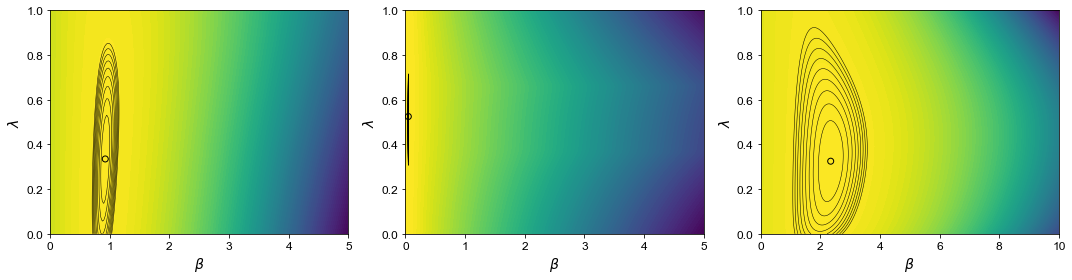

In [40]:
fig, axarr = plt.subplots(1, 3, sharex = False, sharey = False, figsize = (15, 4))

results = [sr, deg,  pr]

for i in range(3):
    
    res = results[i]

    hat = estimation.get_estimates(res)

#     fig = plt.figure(figsize = (5,4))
#     ax = fig.add_subplot(111)

    M_ = res['M']

    xg, yg = np.meshgrid(res['BETA'], res['LAMBDA'])

    im = axarr[i].contourf(xg, yg, M_/n_obs, levels = 100)
    axarr[i].contour(xg, yg, M_/n_obs, 
               levels = np.linspace(M_.max()/n_obs - .01, 
                                    M_.max()/n_obs, 10), 
               linewidths = .5, 
               colors = 'black', 
               linestyles = 'solid')

#     plt.colorbar(im)

    axarr[i].set(xlabel = r'$\beta$',
           ylabel = r'$\lambda$')

    beta_hat = hat['beta']
    lambda_hat = hat['lambda']

    axarr[i].scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')
    
    plt.tight_layout()

# Time-Series Visualization

Now that we have plausible(??) values for $\lambda$ and $\beta$, we can visualize time-series of $\gamma$.

In [32]:
hat = estimation.get_estimates(sr)

BETA = sr['BETA']
LAMBDA = sr['LAMBDA']
M = sr['M']

T_ = T[t_start:,:,:]

tau = timesteps[t_start:]

# t = T_.shape[0]
# lam = lambda_hat
n_rounds = T_.shape[0]
# beta = beta_hat

# def plot_gammas(T, lam, title = '', figsize = (5,4)):
A = estimation.state_matrix(T_, hat['lambda'], A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], hat['beta'])
    
top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

# Comparison of several measures

# A prettier version

The code below just takes these two plots and combines them into a single figure, with some cosmetics. 

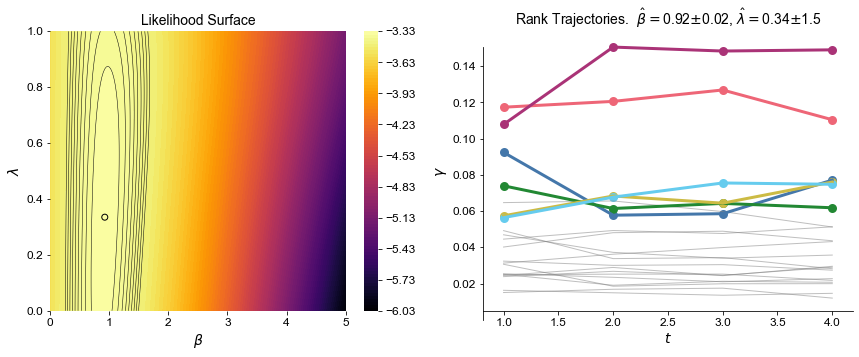

In [33]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


tau = np.arange(timesteps.max())

fig = plt.figure(figsize = (12,5))

ax1 = fig.add_subplot(121)
xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax1.contourf(xg, yg, M/n_obs, levels = 100, cmap = 'inferno')
ax1.contour(xg, yg, M/n_obs, 
           levels = np.linspace((M/n_obs).max()-.1, 
                                (M/n_obs).max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

cb = plt.colorbar(im)
cb.outline.set_visible(False)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax1.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)

ax2 = fig.add_subplot(122)

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

k = 0

for l in range(n):
    if l not in top_trajectories:
        ax2.plot(timesteps, GAMMA[:,l], color = 'grey', alpha = .5, linewidth = 1)

for l in range(n):
    if l in top_trajectories: 
        ax2.plot(timesteps, GAMMA[:,l], alpha = 1, linewidth = 3, 
                 color = cset[k])
        ax2.scatter(timesteps, GAMMA[:,l], alpha = 1, linewidth = 3, 
         color = cset[k])
        k += 1
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_bounds(0, GAMMA.max())


ax2.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Rank Trajectories.  $\hat{\beta} = $' + str(round(hat['beta'], 2)) + r'$\pm$' + str(round(2*hat['s_beta'], 2)) + r', $\hat{\lambda} = $' + str(round(hat['lambda'], 2)) + r'$\pm$' + str(round(2*hat['s_lambda'], 2)))

plt.tight_layout()

plt.savefig('fig/parakeets.png', dpi = 300, bbox_inches = 'tight')